Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import statsmodels.api as sm
from scipy import stats



C:\Users\Amirmahdi\AppData\Local\Temp\ipykernel_7748\163454890.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Read the data and drop redundant columns

In [3]:

listings = pd.read_csv('listingsG.csv')
import json
f = open('variables.json')
variables = json.load(f)
categ_vars = ["host_response_time","host_is_superhost","host_verifications",
        "host_has_profile_pic","host_identity_verified","neighbourhood_cleansed","property_type",
        "room_type","bathrooms_text","instant_bookable"]
listings = listings.drop_duplicates()
column_names = listings.columns.tolist()
listings = listings.drop(columns=['id', 'listing_url', 'scrape_id', 'last_scraped', 'source',
                                  'description', 'host_id', 'picture_url', 'host_id', 'host_since','host_location',
                                  'host_url', 'host_name','host_thumbnail_url','host_picture_url',
                                  'host_neighbourhood','neighbourhood','neighbourhood_group_cleansed',
                                  'amenities','calendar_updated', 'calendar_last_scraped',
                                  'has_availability','first_review','last_review','license', 'name', 'bathrooms', 'bedrooms'])

numer_vars = list(set(listings.columns) - set(categ_vars))




For the categorical variables, we only keep the values which have high amount of occurrence.

In [3]:
values_to_keep = listings['neighbourhood_cleansed'].value_counts().head(10).index.tolist()


listings['neighbourhood_cleansed'] = listings['neighbourhood_cleansed'].where(listings['neighbourhood_cleansed'].isin(values_to_keep), np.nan)

values_to_keep = ['1 bath', '1 shared bath', '1.5 baths', '2 baths', '1 private bath', 
                  '1.5 shared baths', '2.5 baths', '2 shared baths', '3 baths', 'Half-bath']

listings['bathrooms_text'] = listings['bathrooms_text'].where(listings['bathrooms_text'].isin(values_to_keep), np.nan)


values_to_keep = ['Entire rental unit', 'Private room in rental unit', 'Entire condo', 
                      'Private room in home', 'Private room in bed and breakfast', 'Entire home', 
                      'Room in hotel','Private room in condo','Entire serviced apartment','Entire loft']

listings['property_type'] = listings['property_type'].where(listings['property_type'].isin(values_to_keep), np.nan)


Boolean data

In [4]:

listings['neighborhood_overview'] = (~listings['neighborhood_overview'].isna()).astype(int)
listings['host_about'] = (~listings['host_about'].isna()).astype(int)


One-hot-encoding of categorical variables

In [5]:
# Assigns -1 to nan values
for column in categ_vars:
    listings[column] = listings[column].astype('category').cat.codes
listings = pd.get_dummies(listings, columns= categ_vars, drop_first=True)

Transforming some of the numerical columns to numbers

In [6]:
listings['host_response_rate'] = listings['host_response_rate'].str.rstrip('%').astype(float)
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.rstrip('%').astype(float)

listings = listings.dropna(subset=['price'])
listings['price'] = listings['price'].str.replace('$', '').str.replace(',', '').astype(float)

Data Imputation

In [7]:
columns_to_impute = listings.columns[listings.isnull().any()]

listings = listings.fillna(listings.mean())


Log transform of the target variable

In [8]:
listings["price"]=np.log(listings["price"])

We used backward elimination to simplify our model and make sure it only includes important variables that really affect our target, which is 'price'. 
This way, our model gets better at making predictions and is easier to understand, as it only uses the most necessary information.

In [10]:
def backwardElimination(x, y, sl, columns):
    numVars = x.shape[1]
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j] == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                   
    regressor_OLS.summary()
    return x, columns
 
# listings is DataFrame and numer_vars is a list of numerical column names
X = listings[numer_vars]
if 'price' in numer_vars:
    X = X.drop('price', axis=1)
y = listings['price']
 
SL = 0.05
X_Modeled, important_features2  = backwardElimination(X.values, y.values, SL, X.columns)

important_features2 = list(important_features2) 

print('The selected columns are:', important_features2)

The selected columns are: ['maximum_nights', 'availability_60', 'review_scores_value', 'calculated_host_listings_count', 'review_scores_location', 'number_of_reviews_l30d', 'minimum_maximum_nights', 'host_acceptance_rate', 'longitude', 'review_scores_rating', 'calculated_host_listings_count_private_rooms', 'host_response_rate', 'review_scores_communication', 'accommodates', 'calculated_host_listings_count_entire_homes', 'minimum_minimum_nights', 'number_of_reviews']


Data Augmentation. We create 4 datasets.

In [11]:
# Append 'price' to the list of column names
columns_to_include = important_features2 + ['price']

# Create the new DataFrame
listings_1 = listings[columns_to_include]

In [12]:
non_numer_vars = list(set(listings.columns) - set(numer_vars))

# Concatenate the two lists of column names
columns_to_include = non_numer_vars + important_features2 + ['price']

# Create the new DataFrame
listings_2 = listings[columns_to_include]

In [13]:
# add the squared values of the numerical columns to the DataFrame
listings_1_squared = listings_1.copy()
for column in listings_1.columns:
    listings_1_squared[column + '_squared'] = listings_1[column] ** 2

# Display the new DataFrame
listings_1_squared.drop('price_squared', axis=1, inplace=True)

In [14]:
# the dataframe including both the categorical and the squared numerical columns
listings_2_squared = pd.concat([listings_2[non_numer_vars], listings_1_squared], axis=1)

In [15]:
def normalize_and_run_models(df):
    # Separate features (X) and target (y)
    X = df.drop('price', axis=1)
    y = df['price']

    # Normalize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # print(X_train, X_test, y_train, y_test)

    # Create and fit models
    models = [
        LinearRegression(),
        Ridge(),
        Lasso(alpha=0.1),
        RandomForestRegressor(),
        AdaBoostRegressor(),
        XGBRegressor(objective ='reg:squarederror')
    ]
    for model in models:
        model.fit(X_train, y_train)

    # Make predictions using each model and calculate metrics
    results = []
    for model in models:
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        n = len(X_test)
        p = X_test.shape[1]
        adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
        model_sm = sm.OLS(y_test, sm.add_constant(predictions))
        res = model_sm.fit()
        aic = res.aic
        bic = res.bic
        results.append([mse, r2, adjusted_r2, aic, bic])

    return results

results_1 = normalize_and_run_models(listings_1)
results_2 = normalize_and_run_models(listings_2)
results_1_squared = normalize_and_run_models(listings_1_squared)
results_2_squared = normalize_and_run_models(listings_2_squared)

In [16]:

# Define the model names and metric names
model_names = ['Linear Regression', 'Ridge', 'Lasso', 'Random Forest', 'AdaBoost', 'XGBoost']
metric_names = ['MSE', 'R-squared', 'Adjusted R-squared', 'AIC', 'BIC']

# Create a DataFrame for each set of results
df_results_1 = pd.DataFrame(results_1, columns=metric_names, index=model_names)
df_results_2 = pd.DataFrame(results_2, columns=metric_names, index=model_names)
df_results_1_squared = pd.DataFrame(results_1_squared, columns=metric_names, index=model_names)
df_results_2_squared = pd.DataFrame(results_2_squared, columns=metric_names, index=model_names)

# Display the results
print("Results with only numeric variables:")
print(df_results_1)
print("\nResults with numeric and categorical variables:")
print(df_results_2)
print("\nResults with numeric variables and their squares:")
print(df_results_1_squared)
print("\nResults with numeric and categorical variables and their squares:")
print(df_results_2_squared)

Results with only numeric variables:
                        MSE  R-squared  Adjusted R-squared         AIC  \
Linear Regression  0.200819   0.461184            0.438734  528.029655   
Ridge              0.201683   0.458866            0.436319  529.867957   
Lasso              0.235034   0.369385            0.343109  559.561290   
Random Forest      0.159349   0.572452            0.554637  422.350044   
AdaBoost           0.260482   0.301103            0.271982  588.530383   
XGBoost            0.191196   0.487004            0.465630  491.963808   

                          BIC  
Linear Regression  536.138533  
Ridge              537.976835  
Lasso              567.670169  
Random Forest      430.458923  
AdaBoost           596.639262  
XGBoost            500.072687  

Results with numeric and categorical variables:
                        MSE  R-squared  Adjusted R-squared         AIC  \
Linear Regression  0.166214   0.554034            0.476421  445.945936   
Ridge              0.16

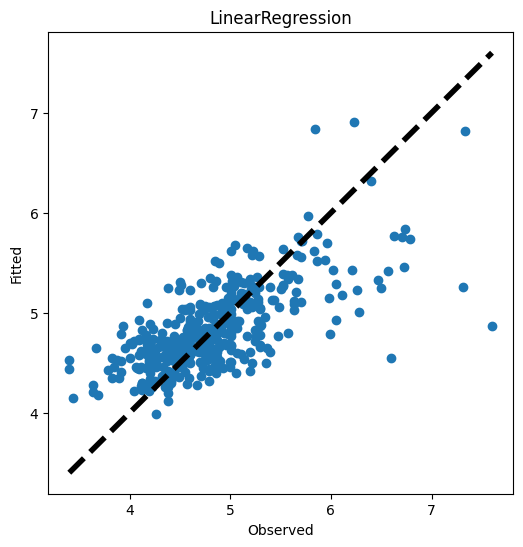

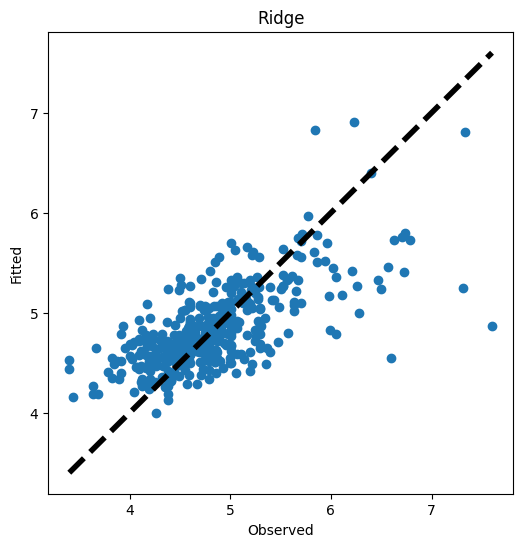

[-0.          0.          0.         -0.          0.          0.
  0.         -0.         -0.          0.         -0.         -0.
 -0.          0.          0.          0.          0.25583039]


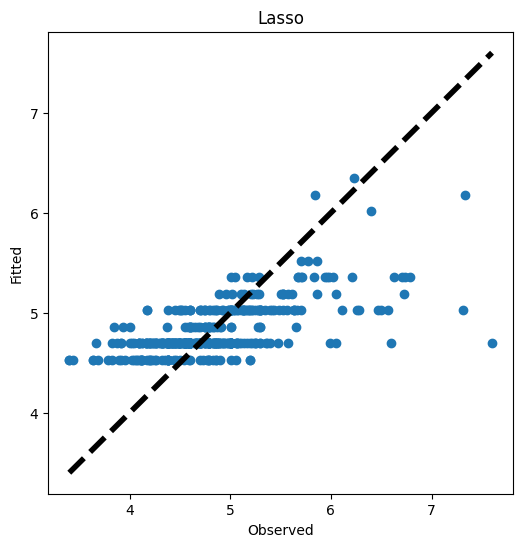

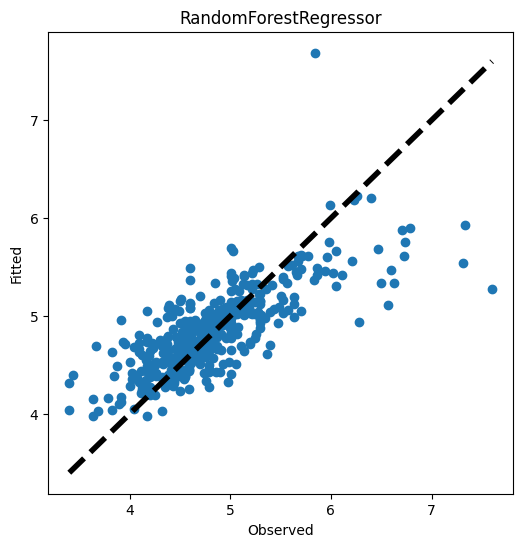

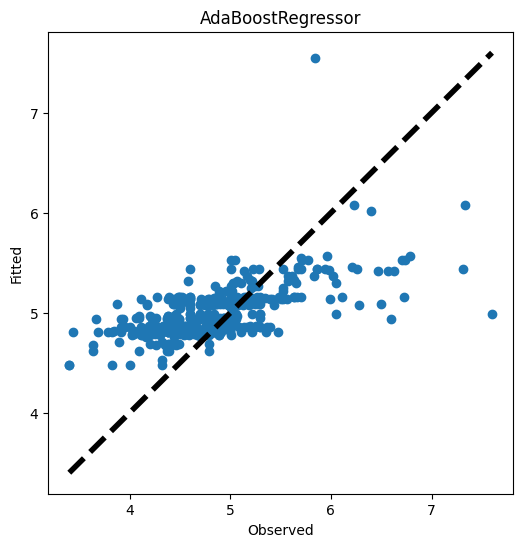

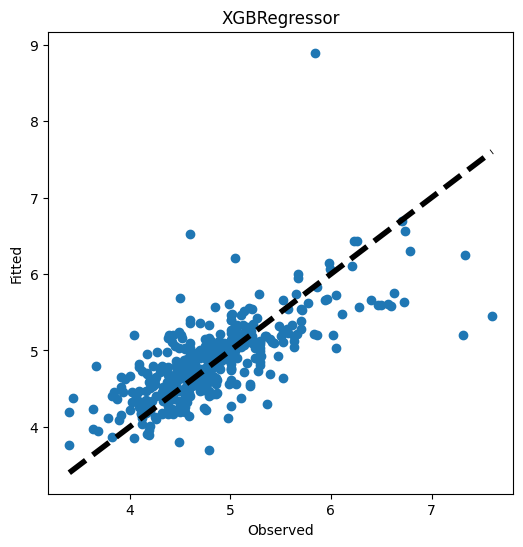

In [39]:
def run_models_and_plot(df, target_column):
    # Separate features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Normalize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and fit models
    models = [
        LinearRegression(),
        Ridge(),
        Lasso(alpha=0.1),
        RandomForestRegressor(),
        AdaBoostRegressor(),
        XGBRegressor(objective ='reg:squarederror')
    ]
    model_names = ['LinearRegression', 'Ridge', 'Lasso', 'RandomForestRegressor', 'AdaBoostRegressor', 'XGBRegressor']

    # Make predictions using each model and plot observed vs fitted values
    for model, name in zip(models, model_names):
        model.fit(X_train, y_train)
        # if name == 'Lasso':
        #     print(model.coef_)
        predictions = model.predict(X_test)

        # Plot observed vs fitted values
        plt.figure(figsize=(6, 6))
        plt.scatter(y_test, predictions)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
        plt.xlabel('Observed')
        plt.ylabel('Fitted')
        plt.title(name)
        plt.show()

run_models_and_plot(listings_1, 'price')

Testing:\
1)the null that all squared terms are zero \
2)the null that the categorical are zero

In [25]:
mse2 = df_results_2['MSE']['Linear Regression']
r2_2 = df_results_2['R-squared']['Linear Regression']

mse2_squared = df_results_2_squared['MSE']['Linear Regression']
r2_2_squared = df_results_2_squared['R-squared']['Linear Regression']

mse1 = df_results_1['MSE']['Linear Regression']
r2_1 = df_results_1['R-squared']['Linear Regression']

In [31]:
X2 = listings_2.drop('price', axis=1)
y2 = listings_2['price']

X2_squared = listings_2_squared.drop('price', axis=1)

X1 = listings_1.drop('price', axis=1)

Null that the squared values of numerical columns are zero

In [36]:
# Number of predictors in each model (excluding the intercept)
p_nested = X2.shape[1]  # Number of predictors in model4
p_full = X2_squared.shape[1]    # Number of predictors in model6
n = len(y2)        # Number of observations in the test set

# Calculating the F-statistic
numerator = (r2_2_squared - r2_2) / (p_full - p_nested)
denominator = (1 - r2_2_squared) / (n - p_full - 1)
F_statistic = numerator / denominator

# Calculating the p-value
df1 = p_full - p_nested  # Degrees of freedom for the numerator
df2 = n - p_full - 1     # Degrees of freedom for the denominator
p_value = 1 - stats.f.cdf(F_statistic, df1, df2)

# Recalculate the p-value now that stats is imported
p_value = 1 - stats.f.cdf(F_statistic, df1, df2)

F_statistic, p_value


(7.283716389554138, 1.1102230246251565e-16)

Null that the dummies are zero

In [30]:
# Number of predictors in each model (excluding the intercept)
p_full = X2.shape[1]  # Number of predictors in model4 (full model)
p_nested = X1.shape[1]    # Number of predictors in model5 (nested model)
n = len(y2)        # Number of observations in the test set for model4

# Calculating the F-statistic
numerator = (r2_2 - r2_1) / (p_full - p_nested)
denominator = (1 - r2_2) / (n - p_full - 1)
F_statistic = numerator / denominator

# Calculating the p-value
df1 = p_full - p_nested  # Degrees of freedom for the numerator
df2 = n - p_full - 1     # Degrees of freedom for the denominator
p_value = 1 - stats.f.cdf(F_statistic, df1, df2)

F_statistic, p_value


(9.337218611197336, 1.1102230246251565e-16)